## Model 2
This notebook performs optimization for model 2 -- Minimize weighted distance by placing new grocery stores simultaneously

### Inputs:
- relevant_buildings.shp
- usda_lowincomelowaccess.csv

### Pre-optimization setup:
0. **Filter buildings to only those in Low Income, Low Access Census tracts** (LILA). This is a key difference from Model 1 and baseline's methodology.
1. Allocate a population count to each residential building (using same methodology as in helper_population_allocation)
2. Use the helper_distance_calculation.py to calculate existing access and distance between a residential and commercial building
3. **Assume no buildings in these tracts have existing access.** This is another key difference from Model 1 and baseline's methodology
4. Once 0-4 are done, all parameters are ready. 

### Model 2 methodology and outputs
1. The analytical formulation is provided below in the 'optimization' section of the code, with detailed comments
2. We first run the model to place only one store, and report results/analysis of this placement
3. We then run the model to place three stores simultaneously, and report results/analysis of these three stores being placed
4. Finally, we also run model 1 on this LILA subset dataset, placing 3 stores, to be able to directly compare what model 1 and
model 2 do. This is to see whether the greedy approach vs. simultaneous approach makes a difference.

In [4]:
# Import libraries
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import haversine as hs
import gurobipy as gp
from gurobipy import GRB
from shapely import wkt

# Helper modules
import helper_population_allocation as pa
import helper_distance_calculation as dc

# Avoid printing set copy warnings
import warnings
warnings.filterwarnings("ignore")

### PRE-OPTIMIZATION SETUP

In [5]:
# Get the main buildings dataset 
buildings_df = gpd.read_file('../processed_data/relevant_buildings.shp')

# Create ID variable for each building
buildings_df.reset_index(drop=True, inplace=True)
buildings_df['building_id'] = buildings_df.index + 1
buildings_df['building_id'] = buildings_df.apply(lambda row: str(row['building_id']) + '-' + str(row['CLASS']) , axis=1)

#### Key difference from model 1 and baseline: the code below filters buildings to only Low Income, Low Access tracts, as defined by USDA

This model is much more computationally intensive than model 1 and baseline, so we limit the dataset to only these 10 census tracts.

In [6]:
# The GeoIDs used by WPRDC don't mape well to the ACS data or USDA low income, low access
# The code below fixes this issue by doing a spatial join with ACS data, to get the 'correct' geoids

# Get ACS data
acs_data = pd.read_csv('../processed_data/ACSData.csv')
acs_data = acs_data[['geometry', 'geo_id', 'B01003_001E', 'B25010_001E']]
acs_data['geometry'] = acs_data['geometry'].apply(wkt.loads) # convert acs data to polygons
acs_data = gpd.GeoDataFrame(acs_data, geometry = 'geometry').set_crs(buildings_df.crs) # turn into polygons

# Do a spatial join from acs to buildings_df to get the propert geo_ids
buildings_df = buildings_df.sjoin(acs_data, how="left", predicate='intersects')
# the last six characters in geoid is the tract ID
buildings_df['geo_id'] = buildings_df['geo_id'].str[-6:] 

# Dropping duplicates created by the spatial join
buildings_df = buildings_df.drop_duplicates(subset=['building_id'], keep='first')

In [7]:
# Import usda low income low access data (LILA)
usda_lila = pd.read_csv('../input_data/usda_lowincomelowaccess.csv')

# Keep relevant columns
usda_lila = usda_lila[['Allegheny_Tracts_GEOID','USDA_Data_LILATracts_1And10','USDA_Data_LILATracts_halfAnd10']]

# Get the right tract ID to merge with buildings_df
usda_lila['geo_id'] = usda_lila['Allegheny_Tracts_GEOID'].astype(str)
usda_lila['geo_id'] = usda_lila['geo_id'].str[-6:]

# Merge these definitions onto buildings_df
buildings_df = buildings_df.merge(usda_lila, how='left', on='geo_id')

# Drop building_id duplicates
buildings_df = buildings_df.drop_duplicates('building_id')

# If the buildings didn't merge, for now just assume LILA variables are 1, to be conservative
buildings_df[['USDA_Data_LILATracts_1And10','USDA_Data_LILATracts_halfAnd10']].fillna(1,inplace=True)

In [8]:
# How many tracts are LILA
tractlevel_access = buildings_df.groupby('geo_id').aggregate(lila_1_10 = ('USDA_Data_LILATracts_1And10', max))
print('Number of census tracts: 0 = not LILA, 1 = LILA')
tractlevel_access['lila_1_10'].value_counts()

Number of census tracts: 0 = not LILA, 1 = LILA


0.0    125
1.0     10
Name: lila_1_10, dtype: int64

In [9]:
# # Filter out if not LILA at 1 mile
buildings_df = buildings_df[buildings_df['USDA_Data_LILATracts_1And10'] == 1]

In [10]:
# Create arrays to track ordering (residential)
res_buildings = buildings_df[buildings_df['class_reco'].str.contains('Residential')]
res_buildings = res_buildings.sort_values('building_id')
res_buildings = dc.get_geocoordinate(res_buildings, 'geometry')

res_buildings_array = np.array(res_buildings['building_id'])
res_buildings_coordinates_array = np.array(res_buildings['coordinates'])

# Create arrays to track ordering (Commercial)
comm_buildings = buildings_df[buildings_df['class_reco'].str.contains('commercial')]
comm_buildings = comm_buildings.sort_values('building_id')
comm_buildings = dc.get_geocoordinate(comm_buildings, 'geometry')

comm_buildings_array = np.array(comm_buildings['building_id'])
comm_buildings_coordinates_array = np.array(comm_buildings['coordinates'])

print(f'There are now {len(comm_buildings_array)} commercial buildings')
print(f'There are now {len(res_buildings)} residential buildings')

There are now 560 commercial buildings
There are now 10306 residential buildings


In [11]:
# Calculate distances between residential and commercial buildings
res_comm_distance_matrix, res_comm_access_matrix = dc.calculate_access(res_buildings_coordinates_array, comm_buildings_coordinates_array)

# Creating a binary access matrix
# [i,j] indicates whether residential building i and commercial building j are within 0.5 miles of each other
res_comm_access_matrix = res_comm_distance_matrix.copy()
res_comm_access_matrix[res_comm_access_matrix <= 0.5] = 1
res_comm_access_matrix[res_comm_access_matrix != 1] = 0

# Grocery store access: Assume that none of the residential buildings have access, so this is an array of 0s
res_access_array = np.zeros(len(res_buildings_array))

# Create population array 
# ith value indicates the population in the ith building

# generate population numbers
res_buildings['population'] = 0 # baseline is nobody lives in a building
res_buildings.loc[res_buildings['class_reco'] == '1-Unit Residential', 'population'] = 1
res_buildings.loc[res_buildings['class_reco'] == '2-Unit Residential', 'population'] = 2
res_buildings.loc[res_buildings['class_reco'] == '3-Unit Residential', 'population'] = 3
res_buildings.loc[res_buildings['class_reco'] == '4+ Unit Residential', 'population'] = 4
# multiply by average household size
res_buildings['population'] = res_buildings['population']*res_buildings['B25010_001E'] 

res_population_array = np.array(res_buildings['population'])
res_population_array

array([1.94, 1.94, 1.94, ..., 3.68, 3.68, 3.68])

In [12]:
# Create demand matrix - number of unsatisfied customers
res_demand = res_population_array
res_demand[np.where(res_access_array == 1)] = 0 # setting effective demand to zero for buildings that have existing access to a grocery store

### OPTIMIZATION

i = set of all residential buildings,
j = set of all commercial buildings

Parameters:
- n: number of grocery stores to be opened
- weight_i: population at building i (assume this is the same as demand, because no res building has existing access)
- dist_ij: distance from residential building i to commercial building j

Decision variables:
- select_j = 1 if the new grocery store is put in commercial building j, 0 otherwise
- assign_ij = 1 if residential building i is assigned to commercial building j, 0 otherwise

Objective function:

Minimize the following

$$ \sum_j \sum_i (weight_i)*dist_{ij}*assign_{ij}$$

Constraints:
1. Number of stores selected cannot exceed limit: $$ \sum_j select_j \leq n $$  

2. Residential building i can only be assigned to commercial building j if we decided to build a grocery store there: $$ assign_{ij} \leq select_j \: \forall (i,j) $$

3. Residential building i must be assigned to exactly one commercial building: $$ \sum_i \sum_j assign_{ij} = 1 \: \forall i $$




### Optimization: with one store placement

In [13]:
# Parameters
num_commercial_buildings = res_comm_distance_matrix.shape[1]
num_residential_buildings = len(res_demand)
num_stores = 1

# Implement model
m = gp.Model('Facility location')

# Decision variables 
select_one = m.addVars(range(num_commercial_buildings), vtype=GRB.BINARY, name='select') # select location
assign = m.addVars(range(num_residential_buildings), range(num_commercial_buildings), vtype=GRB.BINARY, name='assign') # assignment of residential building to cluster

# Objective function - min total distance from residential buildings to their assigned grocery store, multiplied by demand
m.setObjective(sum(sum(res_demand[i] * res_comm_distance_matrix[i,j] * assign[i, j] for i in range(num_residential_buildings)) for j in range(num_commercial_buildings)))
m.modelSense = GRB.MINIMIZE

# Constraints
m.addConstr(sum(select_one[i] for i in range(len(select_one))) <= num_stores, name='store_limit')

for i in range(num_residential_buildings):
    m.addConstr(sum(assign[i,j] for j in range(num_commercial_buildings)) ==  1) # can only assign each residential building to one store

for i in range(num_residential_buildings):
    for j in range(num_commercial_buildings):
        m.addConstr(assign[i,j] <= select_one[j], name='open2assign') # locations can only be assigned demand if they are selected

# Optimize  
m.optimize()


Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-24
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5781667 rows, 5771920 columns and 17314640 nonzeros
Model fingerprint: 0x23dafd21
Variable types: 0 continuous, 5771920 integer (5771920 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-03, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 0 rows and 0 columns (presolve time = 5s) ...
Presolve removed 0 rows and 0 columns (presolve time = 72s) ...
Presolve removed 0 rows and 0 columns (presolve time = 75s) ...
Presolve removed 0 rows and 0 columns (presolve time = 80s) ...
Presolve removed 0 rows and 0 columns (presolve time = 86s) ...
Presolve removed 0 rows and 0 columns (presolve time = 90s) ...
Presolve removed 0 rows and 0 columns (presolve time = 95s) ...
Pres

### Results Analysis: one store placement

In [14]:
# Which store was chosen?
for i in range(len(select_one)):
    if select_one[i].x == 1:
        # Getting the index in the array
        chosen_store_indices_one = i

# Getting the building ID corresponding to that index
chosen_building_ids_one = comm_buildings_array[i]

# Total new people given access to (remember, we assume that nobody already has access in these low income low access tracts)
x = res_comm_access_matrix[:,i] # residential buildings access matrix with the specific chosen store
tot_new = np.dot(res_population_array, x)

# Printing results
print(f"Chosen store index: {chosen_store_indices_one}, corresponding to building: {chosen_building_ids_one}")
print(f"New access provided to {tot_new} people")

Chosen store index: 554, corresponding to building: 96316-C
New access provided to 2101.2799999999925 people


<AxesSubplot:>

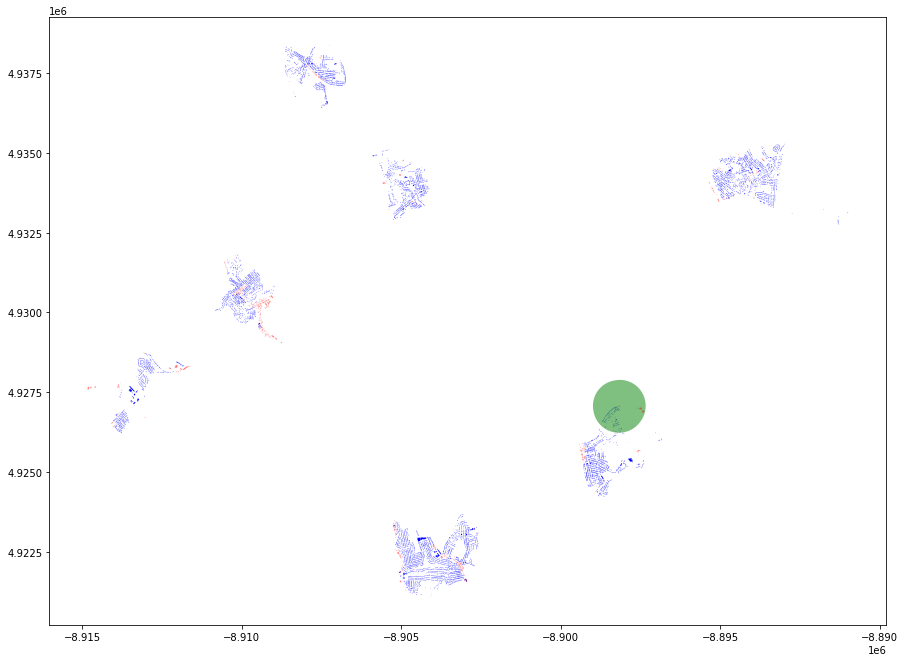

In [25]:
## Plotting results

# All residential buildings
res_buildings = buildings_df[buildings_df['class_reco'].str.contains('Residential')]
res_buildings['geometry'] = res_buildings['geometry'].to_crs(epsg=3857)

# All comm buildings
comm_buildings = buildings_df[buildings_df['class_reco'].str.contains('commercial')]
comm_buildings['geometry'] = comm_buildings['geometry'].to_crs(epsg=3857)

# The chosen building by the model
chosen_building = buildings_df[buildings_df.building_id==chosen_building_ids_one]
chosen_building['geometry'] = chosen_building['geometry'].to_crs(epsg=3857)
chosen_building['geometry'] = chosen_building['geometry'].buffer(804.67) # this buffer on the graph shows the 1/2 mile access provided (in meters)

# Plotting all three on same plot
f, ax = plt.subplots(figsize=(15,15))
res_buildings.plot(ax=ax, color='blue', label='Residential buildings')
chosen_building.plot(ax=ax, alpha=0.5, color='green', label='New stores placement')
comm_buildings.plot(ax=ax, alpha=0.5, color='red', label='Commercial buildings')

### Optimization: three store placement

In [16]:
# Parameters
num_commercial_buildings = res_comm_distance_matrix.shape[1]
num_residential_buildings = len(res_demand)
num_stores = 3

# Implement model
m = gp.Model('Facility location')

# Decision variables 
select = m.addVars(range(num_commercial_buildings), vtype=GRB.BINARY, name='select') # select location
assign = m.addVars(range(num_residential_buildings), range(num_commercial_buildings), vtype=GRB.BINARY, name='assign') # assignment of residential building to cluster

# Objective function - min total distance from residential buildings to their assigned grocery store, multiplied by demand
m.setObjective(sum(sum(res_demand[i] * res_comm_distance_matrix[i,j] * assign[i, j] for i in range(num_residential_buildings)) for j in range(num_commercial_buildings)))
m.modelSense = GRB.MINIMIZE

# Constraints
m.addConstr(sum(select[i] for i in range(len(select))) <= num_stores, name='store_limit')

for i in range(num_residential_buildings):
    m.addConstr(sum(assign[i,j] for j in range(num_commercial_buildings)) ==  1) # can only assign each residential building to one store

for i in range(num_residential_buildings):
    for j in range(num_commercial_buildings):
        m.addConstr(assign[i,j] <= select[j], name='open2assign') # locations can only be assigned demand if they are selected

# Optimize
m.optimize()


Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 5781667 rows, 5771920 columns and 17314640 nonzeros
Model fingerprint: 0x81e997d6
Variable types: 0 continuous, 5771920 integer (5771920 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-03, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 0 rows and 0 columns (presolve time = 5s) ...
Presolve removed 0 rows and 0 columns (presolve time = 53s) ...
Presolve removed 0 rows and 0 columns (presolve time = 56s) ...
Presolve removed 0 rows and 0 columns (presolve time = 60s) ...
Presolve removed 0 rows and 0 columns (presolve time = 65s) ...
Presolve removed 0 rows and 0 columns (presolve time = 70s) ...
Presolve removed 0 rows and 0 columns (presolve time = 75s) ...
Presolve removed 0 rows and 0 columns (presolve time = 80s) ...
Presolve removed 0 rows and 0 c

### Results/analysis: three store placement

In [19]:
# Which stores were chosen?
chosen_store_indices = []
chosen_building_ids = []

for i in range(len(select)):
    if select[i].x == 1:
        chosen_store_indices.append(i)

for i in chosen_store_indices:
    chosen_building_ids.append(comm_buildings_array[i])

# Total new people given access to (remember, we assume that nobody already has access in these low income low access tracts)
new_access_tot = []
for i in chosen_store_indices:
    x = res_comm_access_matrix[:,i] # residential buildings access matrix with the specific chosen store
    tot_new = np.dot(res_population_array, x)
    new_access_tot.append(tot_new)

# Printing results
for i in range(len(chosen_store_indices)):
    print(f'''Chosen store index: {chosen_store_indices[i]}, 
              corresponding to building: {chosen_building_ids[i]}, 
              giving new access to {new_access_tot[i]} people''')

# Total new access provided by all three stores
print(f"Total new access from all three stores: {sum(new_access_tot)}")

Chosen store index: 185, 
              corresponding to building: 48973-R, 
              giving new access to 10894.6 people
Chosen store index: 212, 
              corresponding to building: 6363-R, 
              giving new access to 5054.99000000001 people
Chosen store index: 432, 
              corresponding to building: 83555-R, 
              giving new access to 2700.7200000000093 people
Total new access from all three stores: 18650.31000000002


<AxesSubplot:>

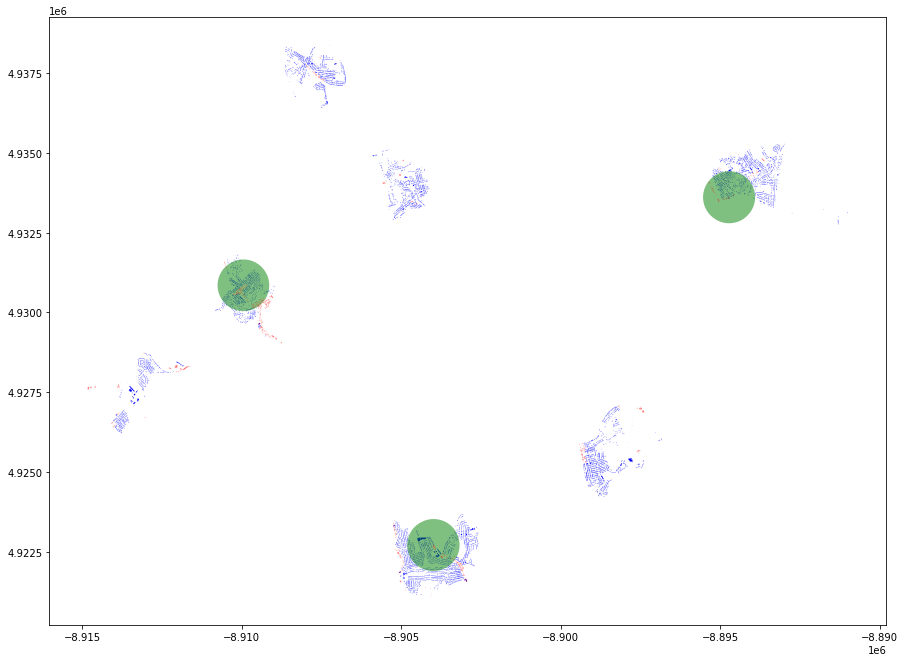

In [20]:
## Plotting results
res_buildings = buildings_df[buildings_df['class_reco'].str.contains('Residential')]
res_buildings['geometry'] = res_buildings['geometry'].to_crs(epsg=3857)

comm_buildings = buildings_df[buildings_df['class_reco'].str.contains('commercial')]
comm_buildings['geometry'] = comm_buildings['geometry'].to_crs(epsg=3857)

chosen_buildings = buildings_df[buildings_df.building_id.isin(chosen_building_ids)]
chosen_buildings['geometry'] = chosen_buildings['geometry'].to_crs(epsg=3857)
chosen_buildings['geometry'] = chosen_buildings['geometry'].buffer(804.67) # this buffer on the graph shows the 1/2 mile access provided (in meters)


# plotting
f, ax = plt.subplots(figsize=(15,15))
res_buildings.plot(ax=ax, color='blue', label='Residential buildings')
chosen_buildings.plot(ax=ax, alpha=0.5, color='green', label='New stores placement')
comm_buildings.plot(ax=ax, alpha=0.5, color='red', label='Commercial buildings')

### Comparison of Model 1 and Model 2 on three-store placement

In [22]:
### Running Model 1 on the data

# Function that runs model 1, placing stores in a greedy way
# See code file 5-Model 1.ipynb for a more detailed explanation of how this works
def place_n_stores(num_stores, access_matrix, access_array):
    store_indices = []
    store_ids = []
    marginal_access_gain = []

    res_access_array_copy = access_array.copy()
    for n in range(num_stores):
        if np.sum(res_access_array_copy) == len(res_buildings_array): # This means every building now has access
            pass
        else:
            # STEP 1
            existing_access_indices = res_access_array_copy.nonzero()[0] # These are indices of residential buildings that currently have access
            res_comm_access_matrix_subset = np.delete(access_matrix, existing_access_indices, axis=0 )

            # STEP 2
            res_population_array_sub = np.delete(res_population_array, existing_access_indices, axis=0)

            # STEP 3
            res_population_array_sub = np.reshape(res_population_array_sub, (-1, len(res_population_array_sub)))
            new_access_array = np.matmul(res_population_array_sub, res_comm_access_matrix_subset)

            chosen_comm_index = np.argmax(new_access_array)
            chosen_comm_building = comm_buildings_array[chosen_comm_index]
            new_access_created = np.max(new_access_array)

            # STEP 4: Update results and arrays
            
            # Which residential buildings does this new store give access to
            new_buildings_with_access = access_matrix[:,chosen_comm_index].nonzero()[0]    # These are the indices in the res_access_array that need to be replaced (these buildings now have access)

            # Update the access values of these buildings in the access array
            replace_vals = list(np.ones(new_buildings_with_access.shape)) # These are the values which with certain elements of the access array will be replaced with

            # Perform replace
            res_access_array_copy[new_buildings_with_access] = replace_vals

            # STEP 5: Store results
            store_indices.append(chosen_comm_index)
            store_ids.append(chosen_comm_building)
            marginal_access_gain.append(new_access_created)

    return store_indices, store_ids, marginal_access_gain


# Run model 1 with 3 stores
m1_indices, m1_ids, m1_new_access = place_n_stores(3, access_array=res_access_array, access_matrix=res_comm_access_matrix)

# Print results from model 1
# Printing results
print('Model 1 results for 3 store placement')
for i in range(len(m1_indices)):
    print(f'''Chosen store index: {m1_indices[i]}, 
              corresponding to building: {m1_ids[i]}, 
              giving new access to {m1_new_access[i]} people''')

# Total new access provided by all three stores
print(f"Total new access from all three stores: {sum(m1_new_access)}")


Model 1 results for 3 store placement
Chosen store index: 183, 
              corresponding to building: 48914-C, 
              giving new access to 11783.449999999997 people
Chosen store index: 212, 
              corresponding to building: 6363-R, 
              giving new access to 5054.990000000045 people
Chosen store index: 534, 
              corresponding to building: 95661-C, 
              giving new access to 2732.400000000009 people
Total new access from all three stores: 19570.84000000005


No handles with labels found to put in legend.


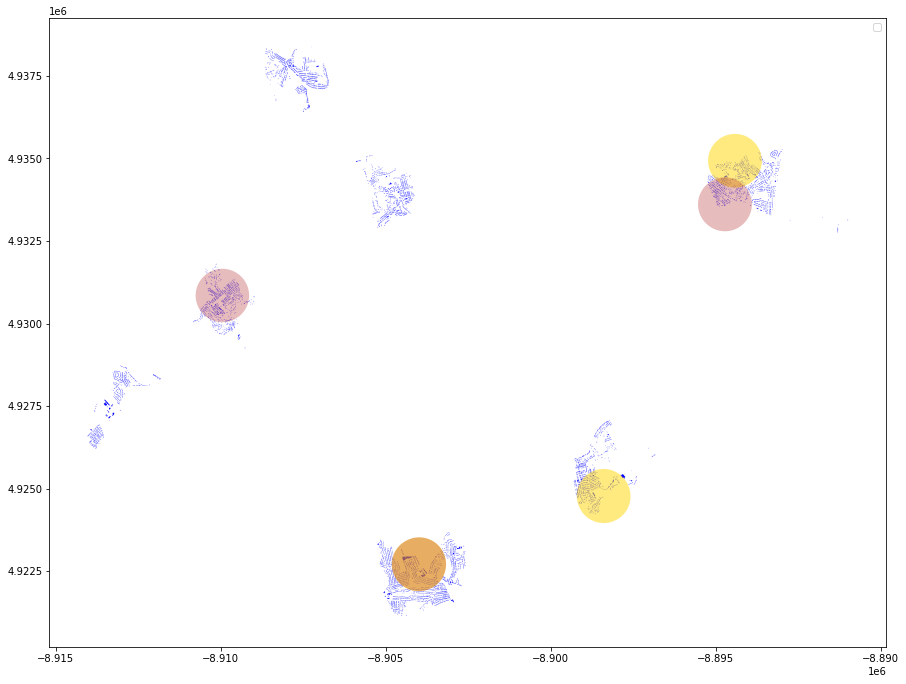

Chosen M1 hoods: 6362                      Carrick
48913    Lincoln-Lemington-Belmar
95660                   Hazelwood
Name: hood, dtype: object
Chosen M2 hoods: 6362                      Carrick
48972    Lincoln-Lemington-Belmar
83554                     Elliott
Name: hood, dtype: object


In [24]:
## Plotting results of both model 1 and model 2 on the same plot, to compare

m2_ids = chosen_building_ids # chosen_store_indices was calculated when running model 2 to place 3 stores

res_buildings = buildings_df[buildings_df['class_reco'].str.contains('Residential')]
res_buildings['geometry'] = res_buildings['geometry'].to_crs(epsg=3857)

comm_buildings = buildings_df[buildings_df['class_reco'].str.contains('commercial')]
comm_buildings['geometry'] = comm_buildings['geometry'].to_crs(epsg=3857)

chosen_buildings_m2 = buildings_df[buildings_df.building_id.isin(m2_ids)]
chosen_buildings_m2['geometry'] = chosen_buildings_m2['geometry'].to_crs(epsg=3857)
chosen_buildings_m2['geometry'] = chosen_buildings_m2['geometry'].buffer(804.67) # this buffer on the graph shows the 1/2 mile access provided (in meters)

chosen_buildings_m1 = buildings_df[buildings_df.building_id.isin(m1_ids)]
chosen_buildings_m1['geometry'] = chosen_buildings_m1['geometry'].to_crs(epsg=3857)
chosen_buildings_m1['geometry'] = chosen_buildings_m1['geometry'].buffer(804.67) # this buffer on the graph shows the 1/2 mile access provided (in meters)

# plotting
f, ax = plt.subplots(figsize=(15,15))
res_buildings.plot(ax=ax, color='blue', label='Residential buildings')
chosen_buildings_m1.plot(ax=ax, alpha=0.5, color='gold', label='New stores M1')
chosen_buildings_m2.plot(ax=ax, alpha=0.3, color='firebrick', label='New stores M2')
ax.legend(loc="upper right")
plt.show()

print(f"Chosen M1 hoods: {chosen_buildings_m1.hood.drop_duplicates()}")
print(f"Chosen M2 hoods: {chosen_buildings_m2.hood.drop_duplicates()}")
